# Köppen-Geiger climate classification #

**Introduction**

In this notebook, we'll use **precipitation flux** and lowest-level **air temperature** data to classify near-surface climate types, following a simplified Köppen-Geiger scheme. For general information, see this [Wikipedia page](https://en.wikipedia.org/wiki/Köppen_climate_classification). For a more detailed background (and a high-resolution dataset based on observational and CMIP model data), see Beck *et al*., 2023. Take at look at the functions defined below and you'll see that this analysis is based on monthly and annual-mean values.

**References**

Beck, H. E., Zimmermann, N. E., McVicar, T. R., Vergopolan, N., Berg, A., and Wood, E. F., 2018. [Present and future Köppen-Geiger climate classification maps at 1-km resolution](https://www.nature.com/articles/sdata2018214). *Scientific Data* **5**, 180214.

**1. Import packages**

In [1]:
import numpy as np
import iris, matplotlib
import iris.coord_categorisation
import iris.plot as iplt
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

**2. Define functions**

In [2]:
def koeppen_geiger(RUNID):
    filein = "run_{RUNID}/output.nc".format(RUNID=RUNID)
    print(filein)
    cube_t = iris.load_cube(filein,'temp')[:,-1,:,:]
    #iris.util.unify_time_units(cube_list)
    #cube = cube_list.concatenate_cube(check_aux_coords=False)
    iris.coord_categorisation.add_month(cube_t, "time")
    cube_t = cube_t.aggregated_by(["month"],iris.analysis.MEAN)
    #cube_t.convert_units('celsius')
    print(cube_t)
    
    filein = "run_{RUNID}/output.nc".format(RUNID=RUNID)
    print(filein)
    cube_p = iris.load_cube(filein,'precip_cond_rate')
    #iris.util.unify_time_units(cube_list)
    #cube = cube_list.concatenate_cube(check_aux_coords=False)
    iris.coord_categorisation.add_month(cube_p, "time")
    cube_p = cube_p.aggregated_by(["month"],iris.analysis.MEAN)
    cube_p.data*=24.*30.4
    cube_p.units = 'mm/month'
    
    shape = cube_p.shape
    new_cube = cube_p[0,:,:].copy()
    new_cube.data *= 0.
    for i in range(shape[1]): 
        for j in range(shape[2]):
            new_cube.data[i,j] = classify_map(cube_t.data[:,i,j],cube_p.data[:,i,j])
    return new_cube

In [3]:
def classify_map(T,P):
    MAT=np.mean(T)
    MAP=np.sum(P)
    # if np.mean(T[3:9])>np.mean(T[[0,1,2,9,10,11]]): 
    #     Ps=P[3:9].copy()
    #     Pw=P[[0,1,2,9,10,11]].copy()
    # else: 
    #     Pw=P[3:9].copy()
    #     Ps=P[[0,1,2,9,10,11]].copy()   
    if np.mean(T[1:3])>np.mean(T[(0,3),]): 
        Ps=P[1:3].copy()
        Pw=P[(0,3),].copy()
    else: 
        Pw=P[1:3].copy()
        Ps=P[(0,3),].copy()   
    if np.mean(Pw)/MAP>0.7:
        P_threshold=2*MAT 
    elif np.mean(Ps)/MAP>0.7:
        P_threshold=2*MAT+28 
    else:
        P_threshold=2*MAT+14

    if(MAP<10.*P_threshold)*(MAP<5.*P_threshold):
        return 4
    elif (MAP<10.*P_threshold)*(MAP>=5.*P_threshold):
        return 5
    elif (MAP>=10.*P_threshold)*(min(T)>=18.)*(min(P)>=60.):
        return 1
    elif (MAP>=10.*P_threshold)*(min(T)>=18.)*(min(P)<60.)*(min(P)>=(100.-MAP/25.)):
        return 2
    elif (MAP>=10.*P_threshold)*(min(T)>=18.)*(min(P)<60.)*(min(P)<(100.-MAP/25.)):
        return 3
    elif (max(T)>10.)*(0.<min(T)<18.)*(min(Ps)<40.)*(min(Ps)<max(Pw)/3):
        return 6
    elif (max(T)>10.)*(0.<min(T)<18.)*(min(Pw)<max(Pw)/10.):
        return 7
    elif (max(T)>10.)*(0.<min(T)<18.)*((min(Pw)>=max(Pw)/10.)+(min(Ps)>=40.)+(min(Ps)>=max(Pw)/3)):
        return 8
    elif ((max(T)>10)*(min(T)<=0))*((min(Ps)<40)*(min(Ps)<max(Pw)/3)):
        return 9
    elif ((max(T)>10)*(min(T)<=0))*(min(Pw)>=max(Pw)/10):
        return 10
    elif ((max(T)>10)*(min(T)<=0))*((min(Ps)>=40)*(min(Ps)>=max(Pw)/3)+(min(Pw)<max(Pw)/10)):
        return 11
    elif (max(T)<=10)*(max(T)>0):
        return 12
    elif (max(T)<=10)*(max(T)<=0):
        return 13

**3. Specify experiment name and run classification**

In [4]:
RUNID = 'control_0003'
cube = koeppen_geiger(RUNID)

run_control_0003/output.nc
temperature / (degC)                (-- : 12; latitude: 64; longitude: 128)
    Dimension coordinates:
        latitude                        -             x              -
        longitude                       -             -              x
    Auxiliary coordinates:
        month                           x             -              -
        time                            x             -              -
    Scalar coordinates:
        sigma layer                 0.9375
    Cell methods:
        0                           month: mean
run_control_0003/output.nc


/opt/jaspy/lib/python3.12/site-packages/iris/common/mixin.py:203: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)
/opt/jaspy/lib/python3.12/site-packages/iris/common/mixin.py:203: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)


**4. Plot and save map**

/opt/jaspy/lib/python3.12/site-packages/iris/coords.py:1980: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.12/site-packages/iris/coords.py:1980: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


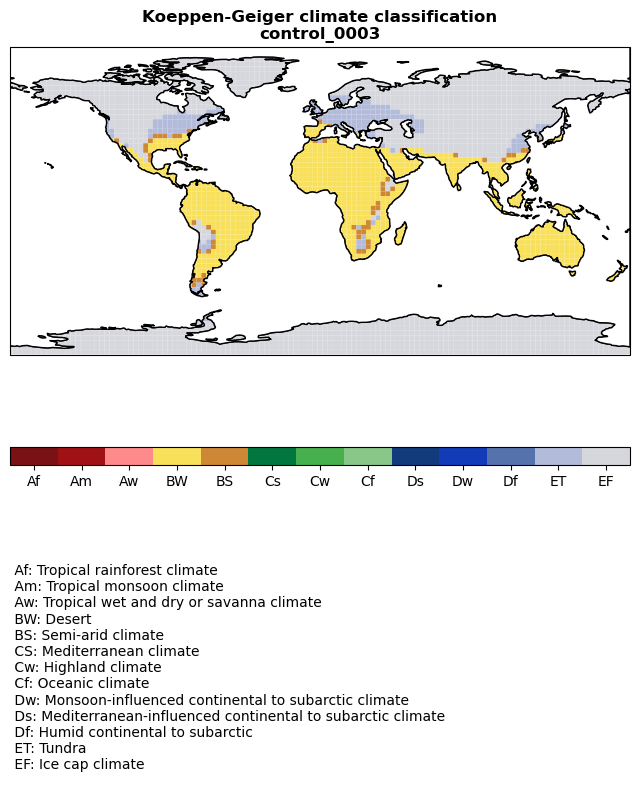

In [9]:
%matplotlib inline

# Colourmap for Af, Am, Aw, BW, BS, Cs, Cw, Cf, Ds, Dw, Df, ET, EF
labels = ['Af', 'Am', 'Aw', 'BW', 'BS', 'Cs', 'Cw', 'Cf', 'Ds', 'Dw', 'Df', 'ET', 'EF']
#cmap = matplotlib.colors.ListedColormap(['blue','dodgerblue','LightBlue','red','orange','Yellow','LightGreen','DarkGreen',
#    'Pink','Purple','Turquoise','LightGray','DarkGray'])
cmap = matplotlib.colors.ListedColormap(np.array([
    [121,17,21],
    [160,17,21],
    [255,138,139],
    [248,224,90],
    [206,136,53],
    [2,118,63],
    [70,176,78],
    [137,199,137],
    [17,59,124],
    [17,59,184],
    [86,114,173],
    [179,187,218],
    [213,215,221]])/255)

# Plot
figure = plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
iplt.pcolor(cube, cmap=cmap, vmin=0.5, vmax=13.5)
plt.gca().coastlines()
cbar=plt.colorbar(orientation='horizontal', ticks=np.arange(1,14), aspect=35)
cbar.ax.set_xticklabels(labels)
ocean_110m = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax1.add_feature(ocean_110m, edgecolor='k')
plt.title('Koeppen-Geiger climate classification\n{RUNID}'.format(RUNID=RUNID),fontweight='bold')
#figure.suptitle('Koeppen-Geiger climate classification for {RUNID}'.format(RUNID=RUNID),fontweight='bold')

# Legend, save
plt.axes(ax1)
plt.text(0,-1.4,
    ' Af: Tropical rainforest climate \n Am: Tropical monsoon climate \n Aw: Tropical wet and dry or savanna climate \n BW: Desert \n BS: Semi-arid climate \n CS: Mediterranean climate \n Cw: Highland climate \n Cf: Oceanic climate \n Dw: Monsoon-influenced continental to subarctic climate \n Ds: Mediterranean-influenced continental to subarctic climate \n Df: Humid continental to subarctic \n ET: Tundra \n EF: Ice cap climate \n',
    transform=ax1.transAxes)

plt.savefig('Koeppen_Geiger_map_{RUNID}.pdf'.format(RUNID=RUNID))
plt.show()